In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
from glob import glob
import pickle

import gpflow
import tensorflow as tf
from sklearn.metrics import r2_score


2025-04-13 08:00:36.107965: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 08:00:36.119355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744552836.129562   61072 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744552836.132910   61072 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-13 08:00:36.145892: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

In [3]:
### Load NROY samples
indir = '/glade/work/linnia/CLM6-PPE/ctsm6_wave1/NROY/'
files = np.sort(glob.glob(indir + 'hmatch_mastersample_*'))
df_list = [pd.read_csv(f) for f in files]
master_sample = pd.concat(df_list, ignore_index=True)

In [12]:
# score and select ensmble
nsets = 500
ntest_samples = 10000
nparams = 236
selected_ix = sample_and_score(master_sample.values,ntest_samples,nsets,nparams)


In [13]:
final_sets = master_sample.iloc[selected_ix]

In [16]:
final_sets.to_csv('./params/wave2_paramsets_041325.csv')

### Write paramsets

In [19]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params_lhc = pd.read_csv(key).drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
                'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

In [14]:
csv='~/ctsm6_ppe/gen_ensembles/gen_paramfiles/ctsm6lhc_paramranges_11262024.csv'
df = pd.read_csv(csv)
df_main = df[df['include'] == 1]
params=df_main['param'].values

In [17]:
filename = './params/wave2_paramsets_041325.csv'
selected_paramsets = pd.read_csv(filename)

In [20]:
# create dictionary of paramsets
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]
pset_dict = {}

for param in params:
    if param in pft_params:
        psets = np.ones((len(selected_paramsets),79))*0.5
        cols = [f"{param}_{i}" for i in pft_ids]
        psets[:,pft_ids] = selected_paramsets[cols].values
        pset_dict[param] = psets
    else:
        pset_dict[param] = selected_paramsets[param].values

In [21]:
# fix some individual PFTs/params
extra_pfts = [0,9,16]
for i in range(20):
    pset_dict['medlynintercept'][i][extra_pfts]= 0.08
# set c3 crops equivalent to c3 grasses
for par in pft_params:
    pset_dict[par][:,15] = pset_dict[par][:,13]

In [22]:
np.save('./params/wave2_paramsets_041325.npy', pset_dict)

### Sanity Check

In [25]:
import pickle
with open("../../utils/biome_pft_dict.pkl", "rb") as f:
    biome_pfts = pickle.load(f)

file='../../biomes/sudoku_biomes.nc'
biomes=xr.open_dataset(file)
biome_names = biomes.biome_names.values

obs = xr.open_dataset('wave2_obsStatistics_sudokuBiomes.nc')

In [24]:
infile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_pxbmean_sudoku_1985-2023.nc'
ds_lhc = xr.open_dataset(infile)
lhc_pxb = ds_lhc.where(ds_lhc['crashed'] != 1, drop=True)
lai_lhc = lhc_pxb.TLAI_biome_amax.sel(year=slice('2001','2020')).mean(dim='year').compute()

In [26]:
# load .npy and reconstruct full sample
num_paramsets = 500 # set the number of ensemble members 
psets_dict = np.load('./params/wave2_paramsets_041325.npy',allow_pickle='TRUE').item()

# Start building a dictionary of all columns
data_dict = {}

# Add scalar/unit-level parameters
data_dict['FUN_fracfixers'] = psets_dict['FUN_fracfixers']
for u in u_params:
    data_dict[u] = psets_dict[u]
    
# Add PFT-level parameters
for p in pft_params:
    data = psets_dict[p]             # shape: (n_samples, n_pfts)
    for j in pft_ids:
        col_name = f"{p}_{j}"
        data_dict[col_name] = data[:, j]  # one column per PFT ID

# Construct the DataFrame once
df = pd.DataFrame(data_dict)
    

2025-04-13 09:06:44.167318: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


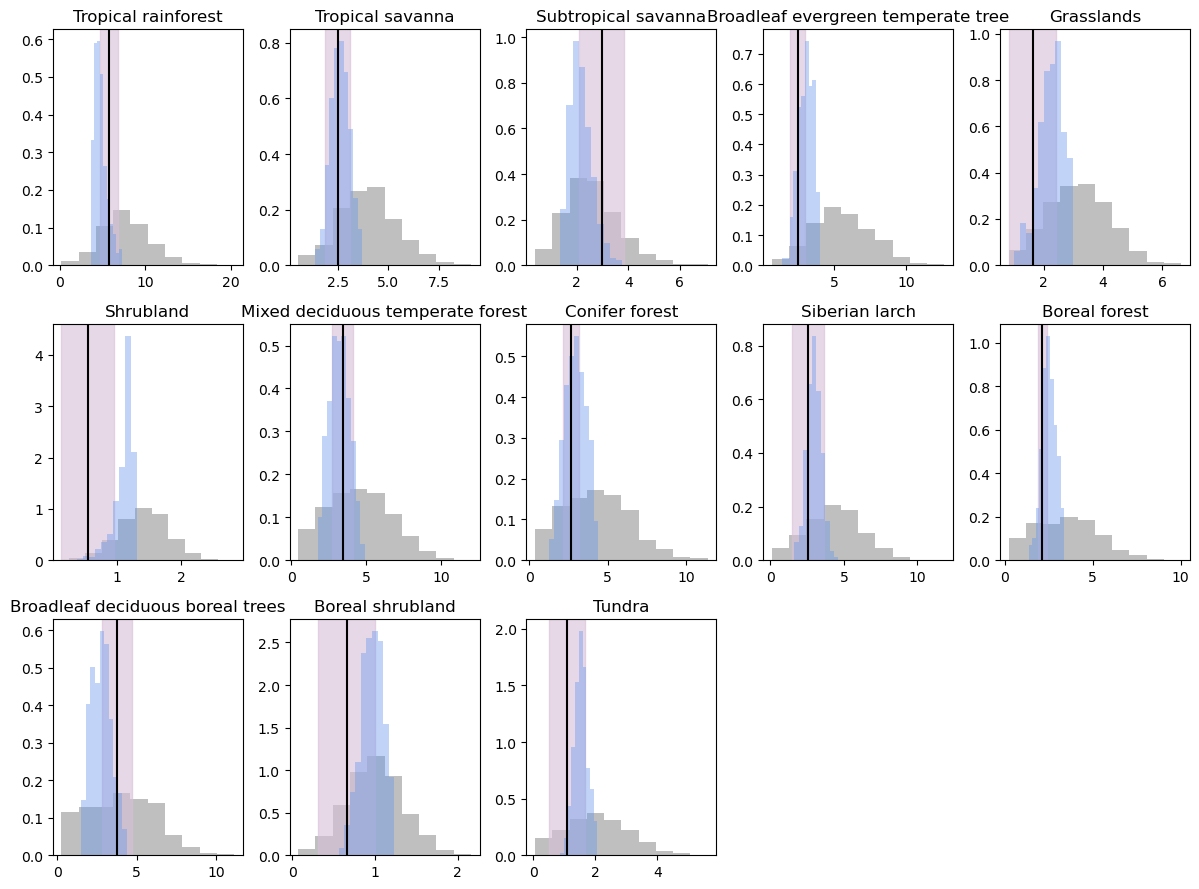

In [27]:
# emulate to check
emulator_dir = 'emulators_biomelai/'

plt.figure(figsize=(12,9))
for b, biome in enumerate(biome_names[1:],start=1):
    plt.subplot(3,5,b)

    obs_mean = obs.LAI_mean.sel(biome=b).values
    obs_var = obs.LAI_stdev.sel(biome=b).values**2

    pfts = biome_pfts[biome]
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = df[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    plt.hist(lai_lhc.isel(biome=b),color='grey',alpha=0.5,density=True)
    plt.axvspan(obs_mean-2*obs_var**0.5,obs_mean+2*obs_var**0.5,color='thistle',alpha=0.6)
    plt.hist(y_pred.numpy().flatten(),alpha = 0.4,color='cornflowerblue',density=True)
    plt.axvline(obs_mean,c='k')
    
    plt.title(biome)

plt.tight_layout()